# Inference of the Huge Transformer Models with NVIDIA FasterTransformer  <br/> and TRITON Inference server <img src="http://developer.download.nvidia.com//notebooks/dlsw-notebooks/gpt-j_and_t5_inference/nvidia_logo.png" style="width: 90px; float: right;">

# Prerequisites

To reproduce all further steps that would be easier to run everything into Docker container with pre-baked triton and triton's fastertransformer_backend <br/> Basic Dockerfile that may be used for image and container creation is placed here: <br/> https://github.com/triton-inference-server/fastertransformer_backend/tree/t5_gptj_blog/docker/Dockerfile 

1. Create the directory where you will run all experiments<br/>
<code>mkdir nv_ft_inference && cd nv_ft_inference</code><br/>
2. Clone fastertransformer_backend repo from GitHub<br/>
<code>git clone https://github.com/triton-inference-server/fastertransformer_backend.git</code> <br/>
<code>cd fastertransformer_backend && git checkout -b t5_gptj_blog remotes/origin/dev/t5_gptj_blog</code>
2. Build docker image using this file<br/>
 <code>docker build --rm  --build-arg TRITON_VERSION=22.03 -t triton_with_ft:22.03 -f docker/Dockerfile .</code>
3. Run docker container <br/>
 <code>cd ../</code><br/>
 <code>docker run -it --rm --gpus=all --shm-size=4G  -v $(pwd):/ft_workspace -p 8888:8888 triton_with_ft:22.03 bash</code>
4. Into the container go to the workspace folder <br/>
 <code>cd /ft_workspace</code>
5. All further steps need to be run into the docker container
6. Jupyter Lab is also needed in this container to work with the notebook provided <br/>
 <code>pip install jupyterlab && jupyter lab --ip 0.0.0.0 --allow-root</code>
7. In jupyter lab open notebook `./fastertransformer_backend/notebooks/GPT-J_and_T5_inference.ipynb`

# Overall pipeline

The overall pipeline of all preparation steps for inference looks like this: 

<center></center>

Let's briefly discuss the steps that we have to do:
* <b>Steps 1, 2:</b> Build docker container with TRITON inference server and FasterTransformer <b> backend</b>. We will use TRITON inference server as the main serving tool and also a custom backend for it `fastertransformer backend`. We've done this step in the `Prerequisites` section. `fastertransformer backend` for TRITON contains examples of TRITON configs for GPT, GPTJ, T5, and other models. That will be used by us. 
* <b>Steps 3, 4:</b> Build FasterTransformer library. This is the library that contains a lot of useful tools for inference preparation as well as bindings for multiple languages and examples how to do inference in C++ and Python.
* <b>Step 5-6:</b> Download weights of the pretrained models (T5-3B and GPT-J) and prepare them for the inference with FT by converting into binary format and splitting them onto multiple partitions for parallelism and accelerated inference. Code from `FasterTransformer` library will be used on this step.
* <b>Step 7:</b> Using code from `FasterTransformer` library we will find optimal low-level kernels for our NN.
* <b>Step 8:</b> Start the TRITON server and run client code to send request to the accelerated models. <br/>
<br/>
Overall three artifacts are needed for TRITON server with fastertransformer to run the inference of the Huge transformer model:
1. <i>Mandatory.</i> TRITON's standard config `config.pbtxt` that describes our model. Its inputs and outputs and additional parameters like a number of tensor_parallelism and pipeline_parallelism partitions. This config should come from Step 1.
2. <i>Mandatory.</i> Weights of the model prepared for the FT backend. We prepare these weights using code after steps 3,4.
3. <i>Optional.</i> Config `gemm_config.in` with numbers of optimal low-level CUDA kernels for our current model and hardware. If this config won't be provided the default inference kernels will be used. This config will be generated by us using code after steps 3,4.


# 1. Download code of the fastertransformer_backend for TRITON Inference Server

Fastertransformer_backend for TRITON Inference Server is already installed into TRITON in our container. So we do not have to do this manually.<br/>
And we download and attached at `/ft_workspace/fastertransformer_backend` directory fasterttransformer_backend code from GitHub to use TRITON's configs for T5 and GPT-J prepared by NVIDIA. <br/>
They are placed at <code>fastertransformer_backend/all_models</code>

Let's create the main folder `triton-model-store` onto our server that will be passed into triton as the main repository/folder with our models and configs for them:

In [ ]:
%cd /ft_workspace

In [ ]:
!mkdir triton-model-store

# 2. Download the code of the FasterTransformer library from GitHub

FasterTransformer library was pre-built and placed into our container as-is. So we do not have to build it manually.<br/>
But we download FasterTransformer code from Github to use additional scripts in it that allows to convert pre-trained files of the GPT-J or T5 into FT binary format that will be used at the inference time.

In [ ]:
!git clone https://github.com/NVIDIA/FasterTransformer.git
%cd FasterTransformer
!git checkout 6b3fd4392831f972d48127e881a048567dd92811
%cd ../

We have to build the library to have the ability to run C++ based code for kernel autotuning later

In [ ]:
%cd FasterTransformer/

In [ ]:
!mkdir -p build
%cd build 

In [ ]:
!git submodule init && git submodule update
!cmake -DSM=xx -DCMAKE_BUILD_TYPE=Release -DBUILD_PYT=ON -DBUILD_MULTI_GPU=ON ..
!make -j32

In [ ]:
%cd ../../

So now we have downloaded and prepared code of the `FasterTransformer` library that helps us to prepare pretrained models for the inference and also we prepared code of the `fastertransformer_backend` that contains TRITON-aware json configs for our GPT-J and T5 models. So we are ready to download pretrained weights of our models and run the inference.

# 3. Run inference of GPT-J or T5 models

## 3.1 GPT-J Inference

### 3.1.1 Overview

Let's have a look at the TRITON's config for the GPT-J model `./fastertransformer_backend/all_models/gptj`:

In [ ]:
!ls ./fastertransformer_backend/all_models/gptj

This config is a perfect demonstration of the TRITON ensembles. TRITON allows you not only to run NNs but construct complex pipes/pipelines. These pipelines may contain multiple NNs connected with each other into one inference task. And also you can add additional Python/C++ scripts before and/or after any Neural network to add any pre/post processing steps that could transform your data into the final form.  <br/>
And in `GPT-J` inference pipeline we have three different steps at the Server-side that goes one after another: <br/> `preprocessing` -> `fastertransformer` -> `postprocessing` <br/> 
And `ensemble` this is the config that combines all these three stages into single pipeline. Overall client-server inference scheme looks like this:

<center>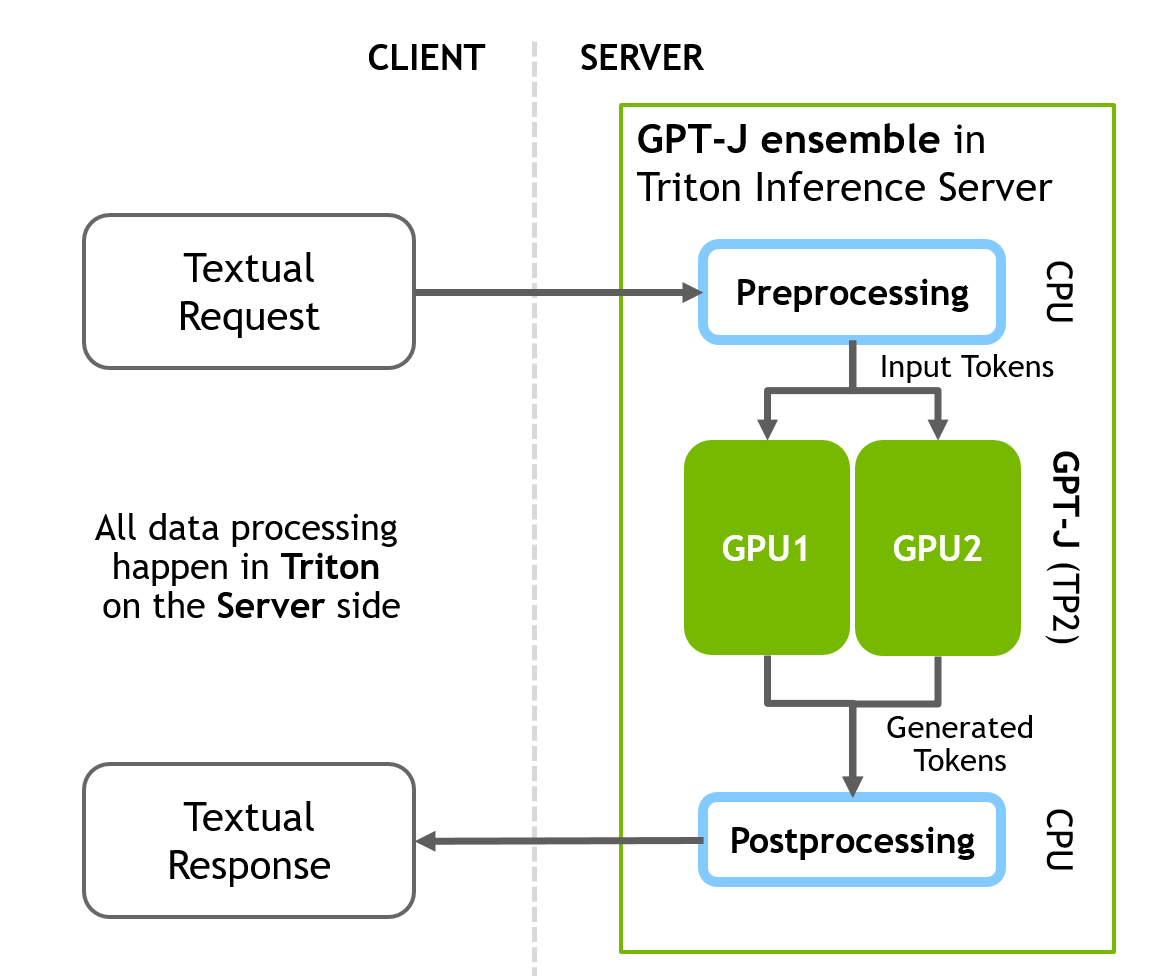</center>


### 3.1.2 Download and prepare weights of GPT-J model

We have to download the weights of the pretrained GPT-J 6b. <br/>


Also, we have to install python libraries:

In [ ]:
!pip3 install jaxlib==0.3.10 jax==0.3.13 transformers==4.19.2

Let's download the weights of the pretrained `GPT-J 6b` model

In [ ]:
!wget https://mystic.the-eye.eu/public/AI/GPT-J-6B/step_383500_slim.tar.zstd
!mkdir models  

Let's unarchive the weights

In [ ]:
!tar -axf step_383500_slim.tar.zstd -C ./models/

Weights for the C++ backend of the FasterTrandformer need to be converted into binary format.<br/>
FasterTransformer provides tools/scripts for different pretrained neural networks. <br/> 
For GPT-J weights you can use this script `FasterTransformer/examples/pytorch/gptj/utils/gptj_ckpt_convert.py` to convert the checkpoint.<br/> 
The converter requires the following arguments: 

1. `--ckpt-dir`: The path of megatron model
2. `--output-dir`: The output path of converted model
3. `--n-inference-gpus`: The tensor parallel size we hope for inference
infer_gpu_num

In [ ]:
!python3 ./FasterTransformer/examples/pytorch/gptj/utils/gptj_ckpt_convert.py \
          --output-dir ./models/j6b_ckpt \
          --ckpt-dir ./models/step_383500/ \
          --n-inference-gpus 2

We re-combined sharded weights into groups of weights that will be placed onto the number of GPUs that we want to use for the inference. For now, these are 2 GPUs

### 3.1.3 GPT-J Kernel auto-tuning

So now we have to do kernel-autotuning. <br/>
Matrix multiplication is the main and the heaviest operation in Transformer-Based neural networks. FT uses functionalities from CuBLAS and CuTLASS libraries to execute this type of operation. It is important to know that MatMul operation can be executed in tens of different ways using different low-level algorithms at the “hardware” level. GemmBatchedEx function implements MatMul operation and has “cublasGemmAlgo_t”  as an input parameter. Using this parameter, you can choose different low-level algorithms for operation. The FasterTransformer library uses this parameter to do a real-time benchmark of all low-level algorithms and to choose the best one for the parameters of the model (Size of the attention layers, number of attention heads, size of the hidden layer, …) and for your input data. Additionally, FT uses hardware-accelerated low-level functions for some parts of the network such as: __expf(), __shfl_xor_sync()<br/><br/>
Let's run `./FasterTransformer/build/bin/gpt_gemm` binary file that was built at the stage of building FasterTransformer library (2nd step). This files takes as an input paramenter of our model as well as additional parameters like 
* `batch_size` 
* `beam_width` 
* `max_input_len` 
* `head_number` 
* `size_per_head`
* `inter_size`
* `vocab_size` 
* `data_type` 
* `tensor_para_size`

All these parameters are needed to do a simulation of the heaviest parts of the neural network we have and run computation of these parts with fake weights and multiple low-level algorithms, to use a couple of the fastest algorithms later during the real inference process.<br/>
We have to set up these parameters manually because only we know what is our model now. For GPT-J model fastertransformer team prepared `../examples/cpp/gptj/gptj_config.ini` config that contains the info about GPT-J model as well as parameters that contains info about the future inference. <br/>
<b>All these tests need to be run onto GPU that will be used for the inference later</b>

In [ ]:
!CUDA_VISIBLE_DEVICES=0  ./FasterTransformer/build/bin/gpt_gemm 8 1 32 12 128 6144 51200 1 2

As a result, we got `gemm_config.in` file in our directory that contains info about algorithms tried and execution time for each algorithm.  
This config file will be used later by `fastertransformer_backend` when we start TRITON server.

### 3.1.4 Prepare the TRITON's config of the GPT-J model

We have weights of the model, prepared for the inference as well as the config about optimal low-level kernels for the inference. We are ready to start TRITON server. <br/>
But we have to provide one more config for the TRITON. TRITON needs to know where our weights are placed, what the model is this, and what inputs and outputs will be for requests and responses. <br/>
Folder `fastertransformer_backend/all_models` contains TRITON configs for the GPT, GPT-J, T5 models. <br/>
Let's copy the config for GPT-J into the new directory to modify it a little bit

In [ ]:
!cp -r ./fastertransformer_backend/all_models/gptj triton-model-store/

#### Update configs of the model

You have to open the main TRITON config for GPT-J model `triton-model-store/gptj/fastertransformer/config.pbtxt`
Only two mandatory parameters need to be changed there to start inference<br/>
<br/>
We have to update tensor_para_size. We prepared our weights for 2 GPU, so we have to sst it equal to "2".<br/>
<code>
parameters {
  key: "tensor_para_size"
  value: {
    string_value: "2"
  }
}
</code> <br/>
We have to update the path to the checkpoint prepared for 2-GPU inference (folder from the previous step) <br/>
<code>
parameters {
  key: "model_checkpoint_path"
  value: {
    string_value: "./models/j6b_ckpt/2-gpu/" 
  }
}
</code> 


### 3.1.5 Start TRITON inference server with TRITON backend and GPT-J

And at that moment we've collected all necessary parts to start the TRITON server and infer GPT-J: <br/> 1. We built and started TRITON docker container with the FasterTransformer backend that supports distributed inference of the GPT-J<br/> 2. We downloaded the model weights and converted them into FT format. <br/> 3. We prepared the TRITON's config 'config.pbtxt' that in a simple json-like manner explains to the TRITON what model will be inferenced, what backend to use for it, and where weights of this model are placed<br/>  Now we are ready to start TRITON inference server.

This command starts TRITON inference server: <br/> 
<code>CUDA_VISIBLE_DEVICES=0,1 /opt/tritonserver/bin/tritonserver  --model-repository=./triton-model-store/gptj/ &</code> <br/>
The main parameter is <code>--model-repository=some_path</code> which points to the directory where placed configs for all your models that you want to infer with TRITON. TRITON will automatically scan through this folder, find model configs inside, loads them into GPUs, and open the HTTP (8000) and GRPC (8001) ports for requests to that models

If TRITON starts successfully, you will see these lines in the output. <br/>
Info about ensemble of GPT-J stages that were found by the TRITON in our directory: <br/>

<code>
+-------------------+---------+--------+
| Model             | Version | Status |
+-------------------+---------+--------+
| ensemble          | 1       | READY  |
| fastertransformer | 1       | READY  |
| postprocessing    | 1       | READY  |
| preprocessing     | 1       | READY  |
+-------------------+---------+--------+</code>
<br/><br/>
Info about that TRITON successfully started and waiting for HTTP/GRPC requests: <br/>

<code>
I0503 17:26:25.226719 1668 grpc_server.cc:4421] Started GRPCInferenceService at 0.0.0.0:8001
I0503 17:26:25.227017 1668 http_server.cc:3113] Started HTTPService at 0.0.0.0:8000
I0503 17:26:25.283046 1668 http_server.cc:178] Started Metrics Service at 0.0.0.0:8002</code>


In [ ]:
import os
os.system("CUDA_VISIBLE_DEVICES=0,1 /opt/tritonserver/bin/tritonserver --log-warning false --model-repository=./triton-model-store/gptj/ &")

In [ ]:
!nvidia-smi

### 3.1.6 Run the client script

Let's run the client code that requests the 8000 port on the localhost to send HTTP requests with text to our model

On the client side we will send textual input to the server using Python's tritonclient library. <br/>
We write simple code that requests the 8000 port on the "localhost" to send HTTP requests with text to our model. <br/>
We will send requests to the "ensemble" model. As we saw in Fig 1.1 this is the model that combines all pre and post processing steps with GPT-J inference to provide a full end-to-end pipeline.<br/>
But we have to remember that TRITON is flexible and we can separately request just GPT-J model or any of these pipeline stages separately. And we will have a look at it later, while we do T5 inference with TRITON and FasterTransformer. 

In [ ]:
import numpy as np
import tritonclient.http as httpclient

from tritonclient.utils import np_to_triton_dtype

URL = "localhost:8000"
MODEl_GPTJ_FASTERTRANSFORMER = "ensemble" 

OUTPUT_LEN = 128
BATCH_SIZE = 1
BEAM_WIDTH = 1
TOP_K = 1
TOP_P = 0.0

start_id = 220
end_id = 50256

Create instance of the `client`:

In [ ]:
client = httpclient.InferenceServerClient("localhost:8000",
                                           concurrency=1,
                                           verbose=False)

Let's implement function `prepare inputs` that prepare input text and other inference hyperparameters such as `Top-k`, `Top-P`, `Temperature`, and others.
There are 15 different hyperparameters that need to be defined for the GPT-J `ensemble` case. 

In [ ]:
# Inference hyperparameters
def prepare_tensor(name, input):
    tensor = httpclient.InferInput(
        name, input.shape, np_to_triton_dtype(input.dtype))
    tensor.set_data_from_numpy(input)
    return tensor

# explanation
def prepare_inputs(input0):
    bad_words_list = np.array([[""]], dtype=object)
    stop_words_list = np.array([[""]], dtype=object)
    input0_data = np.array(input0).astype(object)
    output0_len = np.ones_like(input0).astype(np.uint32) * OUTPUT_LEN
    runtime_top_k = (TOP_K * np.ones([input0_data.shape[0], 1])).astype(np.uint32)
    runtime_top_p = TOP_P * np.ones([input0_data.shape[0], 1]).astype(np.float32)
    beam_search_diversity_rate = 0.0 * np.ones([input0_data.shape[0], 1]).astype(np.float32)
    temperature = 1.0 * np.ones([input0_data.shape[0], 1]).astype(np.float32)
    len_penalty = 1.0 * np.ones([input0_data.shape[0], 1]).astype(np.float32)
    repetition_penalty = 1.0 * np.ones([input0_data.shape[0], 1]).astype(np.float32)
    random_seed = 0 * np.ones([input0_data.shape[0], 1]).astype(np.int32)
    is_return_log_probs = True * np.ones([input0_data.shape[0], 1]).astype(bool)
    beam_width = (BEAM_WIDTH * np.ones([input0_data.shape[0], 1])).astype(np.uint32)
    start_ids = start_id * np.ones([input0_data.shape[0], 1]).astype(np.uint32)
    end_ids = end_id * np.ones([input0_data.shape[0], 1]).astype(np.uint32)

    inputs = [
        prepare_tensor("INPUT_0", input0_data),
        prepare_tensor("INPUT_1", output0_len),
        prepare_tensor("INPUT_2", bad_words_list),
        prepare_tensor("INPUT_3", stop_words_list),
        prepare_tensor("runtime_top_k", runtime_top_k),
        prepare_tensor("runtime_top_p", runtime_top_p),
        prepare_tensor("beam_search_diversity_rate", beam_search_diversity_rate),
        prepare_tensor("temperature", temperature),
        prepare_tensor("len_penalty", len_penalty),
        prepare_tensor("repetition_penalty", repetition_penalty),
        prepare_tensor("random_seed", random_seed),
        prepare_tensor("is_return_log_probs", is_return_log_probs),
        prepare_tensor("beam_width", beam_width),
        prepare_tensor("start_id", start_ids),
        prepare_tensor("end_id", end_ids),
    ]
    return inputs

You can input any prompt for the GPT-J model and press "Enter"

In [ ]:
print("Write any input prompt for the model and press ENTER:")
input_user = input()
input0 = [[input_user],]
inputs = prepare_inputs(input0)

Send the request to the server. <br/>
You will see some console outputs from the Triton server as well. This happens only due to we've started Triton process right into the Jupyter Notebook.

In [ ]:
result = client.infer(MODEl_GPTJ_FASTERTRANSFORMER, inputs)
output0 = result.as_numpy("OUTPUT_0")
print(output0)

## 3.2 T5 inference

<b>Before the next steps, it's better to restart the notebook kernel to stop TRITON server and offload GPT-J model</b>

### 3.2.1 Overview

Let's have a look at the TRITON's config for the GPT-J model `./fastertransformer_backend/all_models/t5`:

In [ ]:
%cd /ft_workspace
!ls ./fastertransformer_backend/all_models/t5

At this time we have only one `fastertransformer` subfolder for our `T5` model. That means that we have only NN inference stage on the Server side and we do not have a full pipeline with preprocessing and postprocessing (that we had in GPT-J). All pre and post processing stages need to e done on the Client side. TRITON allows you to configure your inference flexibly so it's possible to build full pipeline on the server side too, but we want to practice with other configs. So we will do a conversion from text into tokens in Python using Huggingface on the Client side, after that we will send request to the server and after getting a response we convert generated tokens into the text.<br/> 
Overall client-server inference scheme looks like this:

<center>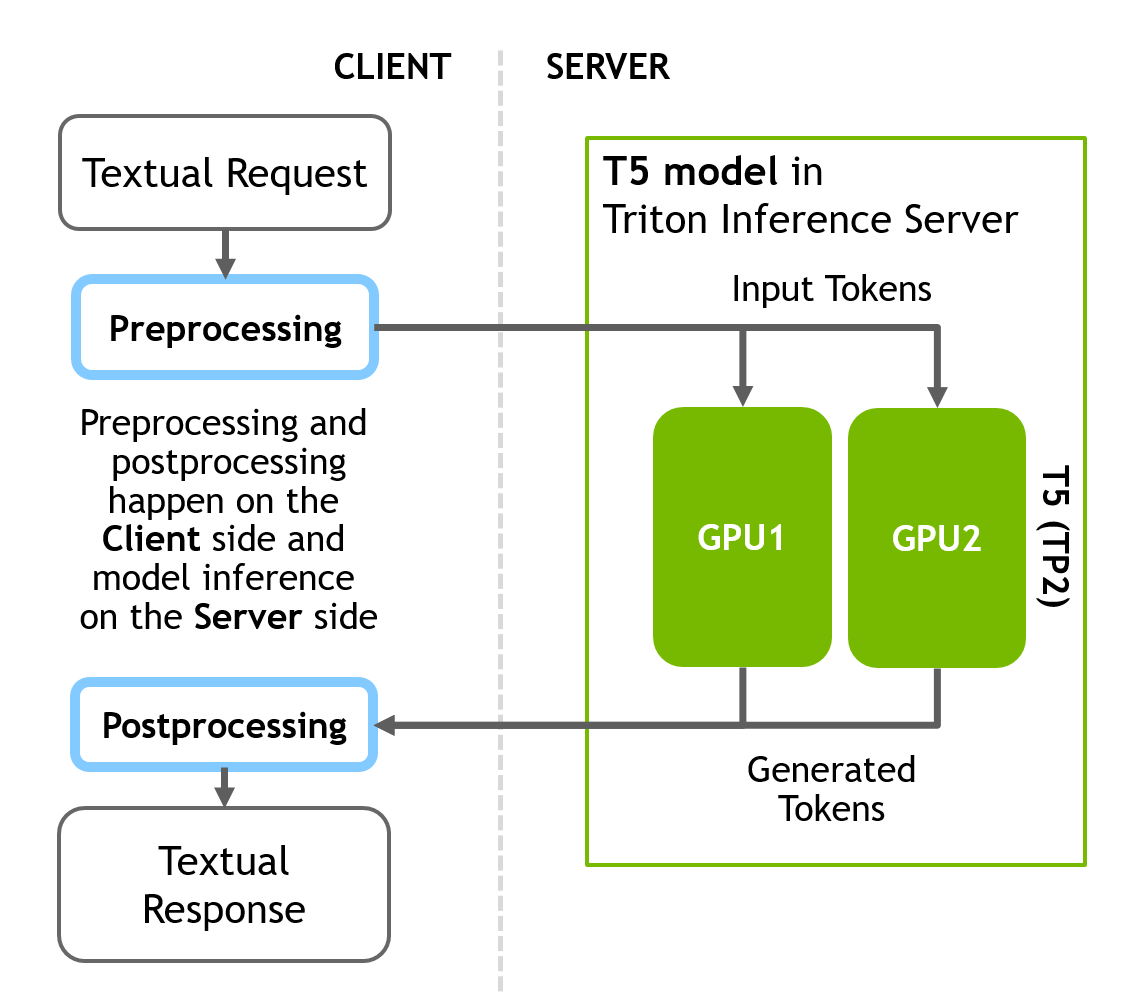</center>

### 3.2.2 Download and prepare weights of T5 model

We have to install additional lib `git-lfs` ("git large files") that allows us to download the weights of the model from HuggingFace repository.

In [ ]:
!git-lfs install

Also, let's install python libraries like Transformers by Hugging face that will be needed by us for checkpoint conversion

In [ ]:
!pip install -r ./fastertransformer_backend/tools/t5_utils/t5_requirement.txt

Let's download weights of the pretrained `t5-3b` model

In [ ]:
!git clone https://huggingface.co/t5-3b

Again for the C++ backend of the FasterTrandformer the weights need to be converted into the binary format.<br/> 
For T5 weights you can use this script `FasterTransformer/blob/main/examples/pytorch/t5/utils/huggingface_t5_ckpt_convert.py` to convert the checkpoint.<br/> 
The converter requires the following arguemtns (quite similar to GPT-J): 

1. `-i`: The path of megatron model
2. `-o`: The output path of converted model
3. `-i_g`: The tensor parallel size we hope for inference
infer_gpu_num
4. `-weight_data_type`: Data type of weights `fp32` or `fp16`

In [ ]:
!python3 FasterTransformer/examples/pytorch/t5/utils/huggingface_t5_ckpt_convert.py \
        -i t5-3b/ \
        -o ./models/t5-3b/ \
        -i_g 2 \
        -weight_data_type fp16

### 3.2.3 T5 kernel auto-tuning

So now we have to do kernel-autotuning for T5 model. <br/>
Let's run `./FasterTransformer/build/bin/t5_gemm` binary file that was built at the stage of building FasterTransformer library (2nd step). This is another one file that contains tests of T5 kernels. It takes as an input paramenter of our model as well as additional parameters like:
* `batch_size`  
* `beam_width` 
* `max_mem_seq_len` 
* `encoder_d_model`
* `encoder_head_num` 
* `encoder_size_per_head` 
* `encoder_inter_size`
* `decoder_d_model`
* `decoder_head_num` 
* `decoder_size_per_head` 
* `decoder_inter_size` 
* `decoder_vocab_size`
* `data_type`
* `tensor_para_size` 
* `is_fp16_compute_type` 
* `is_append`

All these parameters are needed to do a simulation of the heaviest parts of the neural network we have and run computation of these parts with fake weights and multiple low-level algorithms, to use a couple of the fastest algorithms later during the real inference process.<br/>
We have to set up these parameters manually because only we know what is our model now. For GPT-J model fastertransformer team prepared `./models/t5-3b/2-gpu/config.ini` config that contains the info about GPT-J model as well as parameters that contains info about the future inference. <br/>
<b>All these tests need to be run onto GPU that will be used for the inference later</b>

In [ ]:
!CUDA_VISIBLE_DEVICES=0 ./FasterTransformer/build/bin/t5_gemm 1 1 32 1024 32 128 16384 1024 32 128 16384 32128 1 2 1 1

As a result, we got `gemm_config.in` file in our directory that contains info about algorithms tried and execution time for each algorithm.  
This config file will be used later by `fastertransformer_backend` when we start TRITON server.

### 3.2.4 Prepare the TRITON's config of the T5 model

Let's copy the default config for T5 model from `fastertransformer_backend` folder to our `triton-model-store`

In [ ]:
!cp -r ./fastertransformer_backend/all_models/t5/ triton-model-store/

You have to open the copied TRITON config for T5 model `triton-model-store/t5/fastertransformer/config.pbtxt`
Only two mandatory parameters need to be changed there to start inference<br/>
<br/>
We have to update tensor_para_size. We prepared our weights for 2 GPUs, so we have to set it equal to "2".<br/>
<code>
parameters {
  key: "tensor_para_size"
  value: {
    string_value: "2"
  }
}
</code> <br/>
We have to update the path to the checkpoint prepared for 2-GPU inference (folder from the previous step) <br/>
<code>
parameters {
  key: "model_checkpoint_path"
  value: {
    string_value: "./models/t5-3b/2-gpu/" 
  }
}
</code> 

### 3.2.5 Start TRITON inference server with TRITON backend and T5

And at that moment we've collected all necessary parts to start the TRITON server and infer T5: <br/> 1. We built and started TRITON docker container with the FasterTransformer backend that supports distributed inference of the T5<br/> 2. We downloaded the model weights and converted them into FT format. <br/> 3. We prepared the TRITON's config 'config.pbtxt' that in a simple json-like manner explains to the TRITON what model will be inferenced, what backend to use for it, and where weights of this model are placed.<br/>  Now we are ready to start TRITON inference server.

This command starts TRITON inference server: <br/> 
<code>CUDA_VISIBLE_DEVICES=0,1 /opt/tritonserver/bin/tritonserver  --model-repository=./triton-model-store/t5/ &</code> <br/>
The main parameter is <code>--model-repository=some_path</code> which points to the directory where placed configs for all your models that you want to infer with TRITON. TRITON will automatically scan through this folder, find model configs inside, loads them into GPUs and opens the HTTP (8000) and GRPC (8001) ports for requests to that models

If TRITON starts successfully, you will see these lines in the output. <br/>
Info about T5 model that was found by the TRITON in our directory: <br/>

<code>
+-------------------+---------+--------+
| Model             | Version | Status |
+-------------------+---------+--------+
| fastertransformer | 1       | READY  |
+-------------------+---------+--------+</code>
<br/><br/>
Info about that TRITON successfully started and waiting for HTTP/GRPC requests: <br/>

<code>
I0503 17:26:25.226719 1668 grpc_server.cc:4421] Started GRPCInferenceService at 0.0.0.0:8001
I0503 17:26:25.227017 1668 http_server.cc:3113] Started HTTPService at 0.0.0.0:8000
I0503 17:26:25.283046 1668 http_server.cc:178] Started Metrics Service at 0.0.0.0:8002</code>


In [ ]:
!/opt/tritonserver/bin/tritonserver --help

In [ ]:
%cd /ft_workspace/

In [ ]:
import os
os.system("CUDA_VISIBLE_DEVICES=0,1 /opt/tritonserver/bin/tritonserver --log-warning false --model-repository=./triton-model-store/t5/ &")

### 3.2.6 Run the Client script

At this time, on the client side we will transform our textual input to tokens using HuggingFace library and only then send requests to the server using the Python's tritonclient library. We implement function `preprocessing` for this purpose. <br/>
After that we us thee instance of the `tritonclient` that will request the 8000 port on the "localhost" to send tokens to our model through HTTP. <br/>
After we get the response it will contain tokens again and we will transform tokens into text using `postprocessing` function.<br/>

Here, we'll be running our client directly from this notebook. You can also see client.py in this repository for a standalone client application. <br/>
First, we'll import some necessary libraries:

In [ ]:
import sys
from datetime import datetime
import numpy as np
import torch
from transformers import PreTrainedTokenizerFast
from transformers import (
    T5Tokenizer,
    T5TokenizerFast
)  # transformers-4.10.0-py3
import tritonclient.http as httpclient
from tritonclient.utils import np_to_triton_dtype

URL = "localhost:8000"
MODEL_T5_HUGGINGFACE = "t5-3b" # we need this to import tokenizers
MODEl_T5_FASTERTRANSFORMER = "fastertransformer" # name of the model at the TRITON side

torch.set_printoptions(precision=6)

request_parallelism = 10
verbose = False
client = httpclient.InferenceServerClient(
    URL, concurrency=request_parallelism, verbose=verbose
)

 We'll also set some parameters and options for our model. Here we're also loading a tokenizer from the HuggingFace library that we'll use to process our text for the model.

In [ ]:
tokenizer = T5Tokenizer.from_pretrained(MODEL_T5_HUGGINGFACE, model_max_length=1024)
fast_tokenizer = T5TokenizerFast.from_pretrained(MODEL_T5_HUGGINGFACE, model_max_length=1024)

 Using the tokenizer, we'll define some functions to wrap all of our preprocessing and postprocessing logic. These functions are necessary to convert our raw text inputs into the tensors that the model can use, and also to convert the output tensors back into text.

In [ ]:
def preprocess(t5_task_input):
    input_token = tokenizer(t5_task_input, return_tensors="pt", padding=True)
    input_ids = input_token.input_ids.numpy().astype(np.uint32)

    mem_seq_len = (
        torch.sum(input_token.attention_mask, dim=1).numpy().astype(np.uint32)
    )
    mem_seq_len = mem_seq_len.reshape([mem_seq_len.shape[0], 1])
    max_output_len = np.array([[128]], dtype=np.uint32)
    runtime_top_k = (1.0 * np.ones([input_ids.shape[0], 1])).astype(np.uint32)
    
    inputs = [
        httpclient.InferInput(
            "input_ids", 
            input_ids.shape, 
            np_to_triton_dtype(input_ids.dtype)
        ),
        httpclient.InferInput(
            "sequence_length",
            mem_seq_len.shape,
            np_to_triton_dtype(mem_seq_len.dtype),
        ),
        httpclient.InferInput(
            "max_output_len", 
            max_output_len.shape , 
            np_to_triton_dtype(mem_seq_len.dtype)
        ),
        httpclient.InferInput(
            "runtime_top_k", 
            runtime_top_k.shape, 
            np_to_triton_dtype(runtime_top_k.dtype)
        )
    ]
    inputs[0].set_data_from_numpy(input_ids)
    inputs[1].set_data_from_numpy(mem_seq_len)
    inputs[2].set_data_from_numpy(max_output_len)
    inputs[3].set_data_from_numpy(runtime_top_k)
    return inputs

In [ ]:
def postprocess(result):
    ft_decoding_outputs = result.as_numpy("output_ids")
    ft_decoding_seq_lens = result.as_numpy("sequence_length")
    # print(type(ft_decoding_outputs), type(ft_decoding_seq_lens))
    # print(ft_decoding_outputs, ft_decoding_seq_lens)
    tokens = fast_tokenizer.decode(
        ft_decoding_outputs[0][0][: ft_decoding_seq_lens[0][0]],
        skip_special_tokens=True,
    )
    print(tokens)

You can run a variety of tasks on the loaded T5 model.<br/>
Some examples of T5 tasks are:
1. Translation
2. Summarization
3. Sentiment analysis
4. Paraphrasing
5. Sentence completion
6. Sentence Acceptability

#### Question-Answering

Send the request to the server. <br/>
You will see some console outputs from Triton server as well. This happens only due to we've started Triton process right into the Jupyter Notebook.

In [ ]:
text = "question: What does increased oxygen concentrations in the patient’s lungs displace? \
        context: Hyperbaric (high-pressure) medicine uses specialoxygen chambers to increase the partial pressure \
        of O 2 around the patientand, when needed, the medical staff. Carbon monoxide poisoning, \
        gas gangrene,and decompression sickness (the ’bends’) are sometimes treated using thesedevices. \
        Increased O 2 concentration in the lungs helps to displace carbon monoxide from the heme group of hemoglobin. \
        Oxygen gas is poisonous to theanaerobic bacteria that cause gas gangrene, so increasing its partial pressurehelps kill them. \
        Decompression sickness occurs in divers who decompress tooquickly after a dive, resulting in bubbles of inert gas, \
        mostly nitrogen andhelium, forming in their blood. Increasing the pressure of O 2 as soon aspossible is part of the treatment."
inputs = preprocess(text)
result = client.infer(MODEl_T5_FASTERTRANSFORMER, inputs)
postprocess(result)

####  Summarization

In [ ]:
text = "summarize: Transfer learning, where a model is first pre-trained on a data-rich task \
        before being fine-tuned on a downstream task, has emerged as a powerful technique in natural language \
        processing (NLP). The effectiveness of transfer learning has given rise to a diversity of approaches, \
        methodology, and practice. In this paper, we explore the landscape of transfer learning techniques for NLP \
        by introducing a unified framework that converts all text-based language problems into a text-to-text format"
inputs = preprocess(text)
result = client.infer(MODEl_T5_FASTERTRANSFORMER, inputs)
postprocess(result)

#### Translation

In [ ]:
text = "Translate English to German: He swung back the fishing pole and cast the line."
inputs = preprocess(text)
result = client.infer(MODEl_T5_FASTERTRANSFORMER, inputs)
postprocess(result)